# 使用CNN实现图片分类
本样例来自[PyTorch之60min入门教程之PyTorch 图像分类器](http://pytorch123.com/SecondSection/training_a_classifier/)。使用CIFAR10数据集，它包含十个类别：
> classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 输入
$3\times32\times32$的RGB三通道彩色图片
## 输出
图片的类别

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

## 加载数据
使用torchvision加载并归一化CIFAR10的训练和测试数据集。如之前为下载，会先将数据及下载到同目录下data文件夹中。

### 数据处理
使用`torchvision.transforms`对图片数据进行预处理。
* `torchvision.transforms.Compose(transforms)`: 将一系列的transform操作组合起来，用一个`list`包含所有需要执行的操作作为参数
* `torchvision.transforms.ToTensor()`: 将一个`PIL Image`或一个`numpy.ndarray`转化为tensor
* `torchvision.transforms.Normalize(mean, std, inplace=False)`: 使用均值和方差对一个tensor进行归一化，对`n`个通道给出各自的均值$(M_1,...,M_n)$和方差$(S_1,...S_n)$，之后对每个通道的输入按照如下方式归一化：
$$input[channel]=\frac{input[channel] - M_{channel}}{S_{channel}}$$


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 展示部分图片

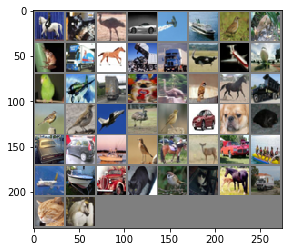

horse   cat  bird   car plane  ship  bird  deer  frog truck horse truck truck  bird plane plane  bird plane truck   dog  bird  bird horse truck  bird  bird plane  bird  bird   car   dog   cat   car   car  ship  bird horse  deer   car  ship plane  ship truck   cat  bird   cat horse truck   cat horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

## 构建模型
* `torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')`：二维卷积层，其参数
    * in_channels (int) – Number of channels in the input image
    * out_channels (int) – Number of channels produced by the convolution
    * kernel_size (int or tuple) – Size of the convolving kernel
    * stride (int or tuple, optional) – Stride of the convolution. Default: 1
    * padding (int or tuple, optional) – Zero-padding added to both sides of the input. Default: 0
    * padding_mode (string, optional) – zeros
    * dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1
    * groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1
    * bias (bool, optional) – If `True`, adds a learnable bias to the output. Default: `True`
    
* `torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)`：二维最大池化层，其参数
    * kernel_size – the size of the window to take a max over
    * stride – the stride of the window. Default value is `kernel_size`
    * padding – implicit zero padding to be added on both sides
    * dilation – a parameter that controls the stride of elements in the window
    * return_indices – if `True`, will return the max indices along with the outputs. Useful for `torch.nn.MaxUnpool2d`
    * ceil_mode – when True, will use ceil instead of floor to compute the output shape

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 使用交叉熵损失函数

In [5]:
import torch.optim as optim

#nn.CrossEntropyLoss()中已包含softmax激活运算
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0 and i > 0:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.090
[1,   200] loss: 1.836
[1,   300] loss: 1.701
[1,   400] loss: 1.614
[1,   500] loss: 1.544
[1,   600] loss: 1.522
[1,   700] loss: 1.492
[1,   800] loss: 1.479
[1,   900] loss: 1.429
[2,   100] loss: 1.388
[2,   200] loss: 1.393
[2,   300] loss: 1.347
[2,   400] loss: 1.320
[2,   500] loss: 1.328
[2,   600] loss: 1.336
[2,   700] loss: 1.295
[2,   800] loss: 1.301
[2,   900] loss: 1.322
[3,   100] loss: 1.255
[3,   200] loss: 1.241
[3,   300] loss: 1.203
[3,   400] loss: 1.216
[3,   500] loss: 1.198
[3,   600] loss: 1.232
[3,   700] loss: 1.201
[3,   800] loss: 1.190
[3,   900] loss: 1.191
[4,   100] loss: 1.152
[4,   200] loss: 1.160
[4,   300] loss: 1.150
[4,   400] loss: 1.128
[4,   500] loss: 1.138
[4,   600] loss: 1.128
[4,   700] loss: 1.140
[4,   800] loss: 1.125
[4,   900] loss: 1.138
[5,   100] loss: 1.067
[5,   200] loss: 1.048
[5,   300] loss: 1.100
[5,   400] loss: 1.082
[5,   500] loss: 1.106
[5,   600] loss: 1.089
[5,   700] loss: 1.053
[5,   800] 

## 测试
对模型进行测试并检查正确率

`torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)`: Returns a namedtuple `(values, indices)` where `values` is the maximum value of each row of the `input` tensor in the given dimension `dim`. And `indices` is the index location of each maximum value found (argmax).

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


### 查看每一类的分类准确率

In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE): # 50: batch_size
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 78 %
Accuracy of  bird : 50 %
Accuracy of   cat : 34 %
Accuracy of  deer : 54 %
Accuracy of   dog : 55 %
Accuracy of  frog : 78 %
Accuracy of horse : 60 %
Accuracy of  ship : 77 %
Accuracy of truck : 66 %
